In [36]:
%%capture
!pip install pyctcdecode
!python -m pip install pypi-kenlm
!pip install jiwer
!pip install bnunicodenormalizer
!pip install -q torchaudio omegaconf



In [37]:
!pip install aksharamukha==2.0.3

# Imports

In [38]:
import os
import numpy as np
from tqdm.auto import tqdm
from glob import glob
from transformers import AutoFeatureExtractor, pipeline
import pandas as pd
import librosa
import IPython
from datasets import load_metric
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import re
import gc
import wave
from scipy.io import wavfile
import scipy.signal as sps

import torchaudio
from IPython.display import Audio, display
from aksharamukha import transliterate
import random

from bnunicodenormalizer import Normalizer 

tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True,nb_workers=8)


print(torch.__version__)
print(torchaudio.__version__)

bnorm=Normalizer()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
1.11.0
0.11.0


# Configs

In [39]:
#according to our experiment this is the best model -> arijitx/wav2vec2-xls-r-300m-bengali
class CFG:
    model_name = 'arijitx/wav2vec2-xls-r-300m-bengali' #arijitx/wav2vec2-large-xlsr-bengali,arijitx/wav2vec2-xls-r-300m-bengali, Tahsin-Mayeesha/wav2vec2-bn-300m
    valid_df_path = '../input/dlsprint/validation.csv'
    sample_sub_df_path = '../input/dlsprint/sample_submission.csv'
    valid = "../input/dlsprint/validation_files/"
    test = "../input/dlsprint/test_files/"
    valid_wav = '../input/validation-fileswav-format/validation_files_wav/'
    test_wav = '../input/test-wav-files-dl-sprint/test_files_wav/'
    batch_size = 48#not using this param now
    single_SPEECH_FILE = "../input/dlsprint/validation_files/common_voice_bn_30620258.mp3"
    post_asr_corrector = False
    



# single sample inference demo

In [40]:
asr = pipeline("automatic-speech-recognition", model=CFG.model_name, device=0)
feature_extractor = AutoFeatureExtractor.from_pretrained(
        CFG.model_name, cache_dir=None, use_auth_token=False
    )
speech, sr = librosa.load(CFG.single_SPEECH_FILE, sr=feature_extractor.sampling_rate)
prediction = asr(
            speech, chunk_length_s=112, stride_length_s=None
        )

pred = prediction["text"]
pred


'তার পিতার নাম কালীপ্রসন্ন ভট্টাচার্য'

# check the original audio

In [41]:
IPython.display.Audio(CFG.single_SPEECH_FILE)

# Fix paths

In [42]:
import os
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

In [43]:
df = pd.read_csv('../input/dlsprint/validation.csv')
directory ="../input/dlsprint/validation_files/"
df["path"]=df["path"].progress_apply(lambda x:os.path.join(directory,str(x)))
df.head(3)

  0%|          | 0/7747 [00:00<?, ?it/s]

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",3.0,0.0,NaN,NaN,NaN,bn
1,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,6.0,1.0,NaN,NaN,NaN,bn
2,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,3.0,1.0,NaN,NaN,NaN,bn


In [44]:
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",3.0,0.0,NaN,NaN,NaN,bn
1,c0494c8220a53efec93f188e32be94d3c1832c48117423...,../input/dlsprint/validation_files/common_voic...,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,6.0,1.0,NaN,NaN,NaN,bn
2,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,3.0,1.0,NaN,NaN,NaN,bn
3,c06b36547c86713d53bb2bf696a34b696de586c5ab1aa9...,../input/dlsprint/validation_files/common_voic...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকার...,3.0,0.0,NaN,NaN,NaN,bn
4,c07f5f84eaa5f8c8dc964033eb96d4c544d2463c51768b...,../input/dlsprint/validation_files/common_voic...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন...",20.0,1.0,NaN,NaN,NaN,bn
...,...,...,...,...,...,...,...,...,...
7742,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি...,2.0,0.0,NaN,NaN,NaN,bn
7743,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।,2.0,1.0,NaN,NaN,NaN,bn
7744,09e250239a19db6c31ba64f9e10340c17508a0a8bdfc66...,../input/dlsprint/validation_files/common_voic...,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?,2.0,0.0,NaN,NaN,NaN,bn
7745,69545be87267c6177baaa60a16a7f474278642c4cec3d8...,../input/dlsprint/validation_files/common_voic...,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।,3.0,0.0,NaN,NaN,NaN,bn


# Custom dataset class

librosa with mp3 is super slow,so we will be using wav files for faster inference

In [45]:
class bn_asr_Dataset(Dataset):
    '''
    args:
        df      : path of the dataframe
        dir     : directory of sound files
    '''
    def __init__(self,df,dir):
        self.df = pd.read_csv(df)
        self.dir = dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
   
        #speech, _ = librosa.load(self.dir+self.df.path[i], sr=feature_extractor.sampling_rate) 
        path = self.dir+self.df.path[i]
        path = os.path.splitext(path)[0]+'.wav'
        # Read file
        sampling_rate, data = wavfile.read(path)
        # Resample data
        number_of_samples = round(len(data) * float(feature_extractor.sampling_rate) / sampling_rate)
        speech = sps.resample(data, number_of_samples)
        return speech
  


# making prediction on whole validation set

In [46]:
%%time

from tqdm import tqdm

#single image inference
''' 
#super slow inference...

predictions = []
references = []
for i in range(len(df.path)):
    speech, sr = librosa.load(df.path[i], sr=feature_extractor.sampling_rate)
    prediction = asr(speech, chunk_length_s=112, stride_length_s=None)
    pred = prediction["text"]
    predictions.append(pred)
    references.append(df.sentence[i])
    
print(len(predictions),len(references))
'''

df = pd.read_csv(CFG.valid_df_path)

valid_dataset = bn_asr_Dataset(CFG.valid_df_path,CFG.valid_wav)#CFG.valid
predictions = []
references = []
# for i,pred_sentence in enumerate(tqdm(asr(valid_dataset, chunk_length_s=112, stride_length_s=None,batch_size=CFG.batch_size), total=len(valid_dataset))):
#     references.append(df.sentence[i])
#     predictions.append(pred_sentence['text'])
    
# use tqdm for progress bar
for i in tqdm(range(len(valid_dataset))):
    pred = asr(valid_dataset.__getitem__(i), chunk_length_s=112, stride_length_s=None)
    references.append(df.sentence[i])
    predictions.append(pred['text'])

100%|██████████| 7747/7747 [24:32<00:00,  5.26it/s]

CPU times: user 22min 7s, sys: 15 s, total: 22min 22s
Wall time: 24min 32s


In [47]:
torch.cuda.empty_cache() 
gc.collect()
!nvidia-smi

Tue May 23 12:46:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |   2197MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# WER (word error rate) calculation process



![](https://miro.medium.com/max/700/1*MUGLdWm3zMYK7dLmyo3pqA.png)

**WER = 100 (insertions(INS) + substitutions(SUB) + deletions(DEL))**

![](http://www.italk2learn.eu/wp-content/uploads/2015/02/speech-bubble-image.png)

# CER (character error rate) calculation process



character error rate (cer) is a common metric of the performance of an automatic speech recognition system. This value indicates the percentage of characters that were incorrectly predicted. The lower the value, the better the performance of the ASR system with a CER of 0 being a perfect score.

CER calculation is based on the concept of [Levenshtein distance](https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510#9bd1), where we count the minimum number of character-level operations required to transform the ground truth text (aka reference text) into the OCR output.

Character Error Rate (CER) formula :

![](https://miro.medium.com/max/700/1*KsWFDKnLI7mudmhbzGjc4w.png)

where:

* S = Number of Substitutions
* D = Number of Deletions
* I = Number of Insertions
* N = Number of characters in reference text (aka ground truth)

Let’s look at an example:

**Ground Truth Reference Text**: 809475127

**ASR Transcribed Output Text**: 80g475Z7

Several errors require edits to transform ASR output into the ground truth:

1. g instead of 9 (at reference text character 3)
2. Missing 1 (at reference text character 7)
3. Z instead of 2 (at reference text character 8)

With that, here are the values to input into the equation:

* Number of Substitutions (S) = 2
* Number of Deletions (D) = 1
* Number of Insertions (I) = 0
* Number of characters in reference text (N) = 9

Based on the above, we get (2 + 1 + 0) / 9 = 0.3333. When converted to a percentage value, the CER becomes 33.33%. This implies that every 3rd character in the sequence was incorrectly transcribed.

We repeat this calculation for all the pairs of transcribed output and corresponding ground truth, and take the mean of these values to obtain an overall CER percentage.

**Reference :** [Evaluate OCR Output Quality with Character Error Rate (CER) and Word Error Rate (WER)](https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510#5aec)

# calculating metric on whole validation set

In [48]:

df = pd.DataFrame(columns=['predictions', 'references'])
df.predictions = predictions
df.references = references


# Unicode Normalizer


from [webinar suplimentary notebook :: DL SPRINT](https://www.kaggle.com/code/nazmuddhohaansary/webinar-suplimentary-notebook-dl-sprint)

In [49]:

def normalize(sen):
    _words = [bnorm(word)['normalized']  for word in sen.split()]
    return " ".join([word for word in _words if word is not None]) 

df.predictions= df.predictions.parallel_apply(lambda x:normalize(x))
df.references= df.references.parallel_apply(lambda x:normalize(x))
df.to_csv('./results.csv',index = False) #use it for error analysis and other stuffs
df.head(10)

,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."
5,এখানে তিনি এয়াকিনসের অধীনে অধ্যয়ন করেছেন,এখানে তিনি এয়াকিনসের অধীনে অধ্যয়ন করেছিলেন।
6,শীতকালীন গেমস এ কোন কোন পদক জিততে পারেনি।,শীতকালীন গেমসে এখনো কোন পদক জিততে পারেনি।
7,অবশেষে তিনি কাবুলে ফিরে আসেন,"অবশেষে, তিনি কাবুলে ফিরে আসেন।"
8,তিনি অ্যাথেলসেএসে চক্রটির শীর্ষ হন,তিনি এথেন্সে এসে সক্রেটিসের শিষ্য হন।
9,তিন বছর বয়সে তার বাবা মারা যান,তিন বছর বয়সে তাঁর বাবা মারা যান।


# Without Post Processing

In [50]:
cer = load_metric("cer")
wer = load_metric("wer")

cer_score = cer.compute(predictions=df.predictions, references=df.references)
print("validation cer_score -> ",cer_score)
wer_score = wer.compute(predictions=df.predictions, references=df.references)
print("validation wer_score -> ",wer_score)

validation cer_score ->  0.09757065617828559
validation wer_score ->  0.3084328285431672


* without bnunicodenormalizer our cv was (as discussed [here](https://www.kaggle.com/competitions/dlsprint/discussion/334951)) :

**validation cer_score -> 0.09787704766628824**

**validation wer_score -> 0.30921300101701055**

* with bnunicodenormalizer our cv is :

**validation cer_score -> 0.09668792125091967**

**validation wer_score -> 0.3049220524108723**

# With  post processing

during error analysis using the results.csv file we've seen that the model is frequently missing to predict punctuations, almost all the sentences in ground truth ends with '।' but while predicting using the public best trained model we can see that the model is missing to predict '।' most of the times, so in the simple post processing code below we will check if the predicted sentence ends with '।' or not,if no then we forcefully add '।' at the end of the predicted sentence.

In [51]:
for i in tqdm(range(len(df.predictions))):
    if(df.predictions[i][-1] == '।'):
        continue
    else:
        df.predictions[i] = df.predictions[i]+'।'

100%|██████████| 7747/7747 [00:00<00:00, 10822.73it/s]


In [52]:
cer_score = cer.compute(predictions=df.predictions, references=df.references)
print("Final validation cer_score -> ",cer_score)
wer_score = wer.compute(predictions=df.predictions, references=df.references)
print("Final validation wer_score -> ",wer_score)

Final validation cer_score ->  0.09252702848203485
Final validation wer_score ->  0.28356483093941126


* without bnunicodenormalizer our post processed model's cv was (as discussed [here](https://www.kaggle.com/competitions/dlsprint/discussion/334951#1856670) ) :

**validation cer_score -> 0.09301847750965592**

**validation wer_score -> 0.28501372267654884**

* with bnunicodenormalizer our final cv (with post processing) is :

**validation cer_score -> 0.09173650517129109**

**validation wer_score -> 0.28054166260326835**

#  with bnunicodenormalizer we've got 0.004472060073280493 WER improvement

# Submission with post processing

In [53]:
df = pd.read_csv('../input/dlsprint/sample_submission.csv')
len(df.path)

7747

In [54]:
%%time

test_dataset = bn_asr_Dataset(CFG.sample_sub_df_path,CFG.test_wav)

# for i,prediction in enumerate(tqdm(asr(test_dataset, chunk_length_s=112, stride_length_s=None,batch_size=CFG.batch_size), total=len(test_dataset))):
#     df.sentence[i] = prediction["text"]
    
for i in tqdm(range(len(test_dataset))):
    pred = asr(test_dataset.__getitem__(i), chunk_length_s=112, stride_length_s=None)
    
    #applying simple post processing with error handler
    try:
        if(pred["text"][-1] == '।'):
            df.sentence[i] = pred["text"]
        else:
            df.sentence[i] = pred["text"]+'।'
    except:
        print("predicted text at idx ",i," is -> ",pred["text"])
        df.sentence[i] = pred["text"]+'।'
        
df.sentence=df.sentence.parallel_apply(lambda x:normalize(x)) #unicode normalizer


100%|██████████| 7747/7747 [26:11<00:00,  4.93it/s]


CPU times: user 23min 36s, sys: 18.1 s, total: 23min 54s
Wall time: 26min 45s


In [55]:
df.head(3)

,path,sentence
0,common_voice_bn_31675220.mp3,এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন ...
1,common_voice_bn_31513116.mp3,এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে ...
2,common_voice_bn_31558126.mp3,জন পরিকল্পিত।


In [56]:
df.to_csv('./submission.csv',index = False)
df.sentence[1]

'এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে কুকুর অসুস্থ হয়ে পড়ে।'

In [57]:
IPython.display.Audio('../input/dlsprint/test_files/common_voice_bn_31675220.mp3')

In [58]:
df.sentence[0]

'এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন তিনি।'

In [59]:
df.sentence[80]

'প্রথম শ্রেণির ক্রিকেট প্রতিযোগিতা শেলিল্ডের উদ্বোধনী আসরে অংশ নেয়।'

# optional (post ASR correction attempt)

in this section we will try to implement the recent best research on POST OCR (optical character recognition) CORRECTION titled[ Post-OCR Document Correction with large Ensembles of Character
Sequence-to-Sequence Models](https://arxiv.org/pdf/2109.06264.pdf) this research work was done in ocr domain and not in ASR domain so i was thinking what will happen if we try this approach in ASR domain? **well if you never try you'll never know**.
The core of this system is a standard sequence-to-sequence model that can correct sequences of characters. In the below implementation, we used a Transformer as the sequence model, which takes as input a segment of characters from the document to correct, and the output is the corrected segment. To train this sequence model, it is necessary to align the raw documents with their corresponding correct transcriptions, which is not always straightforward.Since the output is not necessarily of the same length as the input (because of possible insertions or deletions of characters), a decoding method like Greedy Search or Beam Search
is needed to produce the most likely corrected sequence according to the model.
for the below experiment we will be using results.csv where references column contains actual clean annotation and predictions column contains output of STT model including errors


In [60]:
!git clone https://github.com/jarobyte91/post_ocr_correction.git
os.chdir('./post_ocr_correction')
!pwd
!ls

fatal: destination path 'post_ocr_correction' already exists and is not an empty directory.
/kaggle/working/post_ocr_correction
LICENSE    build	     evaluate  notebooks       requirements.txt  tests
README.md  download_data.py  lib       pyproject.toml  setup.cfg	 train


In [61]:
!pip install .

Processing /kaggle/working/post_ocr_correction
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for post-ocr-correction: filename=post_ocr_correction-0.0.1-py3-none-any.whl size=6432 sha256=da66f005286e5933a8e62661563648d804182a86ec64ead97084fbdf5b0daaeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6_5rps_/wheels/72/31/2e/2f7f310c7a5d2c12d18796bf8b5e2a7a79569dcc1f6f07f977
Successfully built post-ocr-correction
  Attempting uninstall: post-ocr-correction
    Found existing installation: post-ocr-correction 0.0.1
    Uninstalling post-ocr-correction-0.0.1:
      Successfully uninstalled post-ocr-correction-0.0.1


In [62]:
os.chdir('..')
!ls

__notebook_source__.ipynb  results.csv	submission.csv
post_ocr_correction	   results.txt


In [63]:
results = pd.read_csv('../input/commonvoice-bn-xls-r-metric-calculation/results.csv')
print(len(results))
preds = results.predictions.tolist()
refs = results.references.tolist()
results.head()

7747


,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."


In [64]:
results

,predictions,references
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।"
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন..."
...,...,...
7742,তবে রোগাক্রান্ত পোশাক বিড়ালের মাধ্যমে এটি বেশি...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি ...
7743,পেল ও সহযোগী পেল সংযাগুলোলুকাস ধারার অন্তর্গত,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।
7744,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কি,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?
7745,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতে পছন্দ করে।,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।


In [65]:
# get random 15 samples
random.seed(42)
random_idx = random.sample(range(0, len(results)), 15)
print(random_idx)

[5238, 912, 204, 6074, 2253, 2006, 1828, 1143, 6033, 839, 5543, 6067, 7308, 4467, 712]


In [66]:
# make a new dataframe and save the results with index
new_results = results.iloc[random_idx]
# show the results
new_results
# convert the dataframe to txt file
new_results.to_csv('results.txt', index=False, sep='\t')

In [ ]:
# import csv


In [67]:
# make some visualization of the results
import matplotlib.pyplot as plt
import seaborn as sns

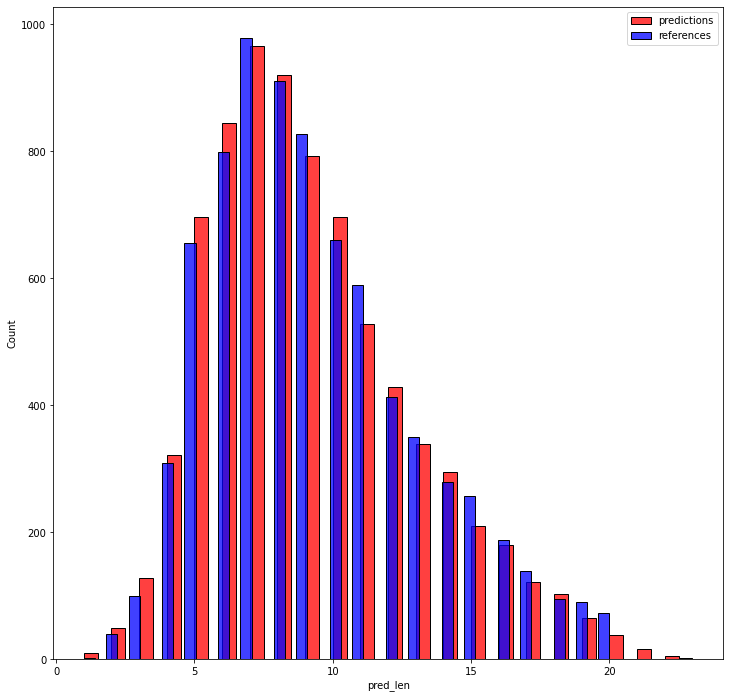

In [68]:
plt.figure(figsize=(12, 12))
results['pred_len'] = results.predictions.apply(lambda x: len(x.split()))
results['ref_len'] = results.references.apply(lambda x: len(x.split()))
sns.histplot(results['pred_len'], color='red', label='predictions')
sns.histplot(results['ref_len'], color='blue', label='references')
plt.legend()
plt.savefig('distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
cer = load_metric("cer")
cer_scores = []
for i in tqdm(range(len(results))):
    cer_scores.append(cer.compute(predictions=[results.predictions[i]], references=[results.references[i]]))
# add the cer scores to the dataframe
results['cer_scores'] = cer_scores

100%|██████████| 7747/7747 [00:28<00:00, 268.23it/s]


In [70]:
wer = load_metric("wer")
# make an empty list to store the wer scores for each sentence
wer_scores = []
for i in tqdm(range(len(results))):
    wer_scores.append(wer.compute(predictions=[results.predictions[i]], references=[results.references[i]]))
# add the wer scores to the dataframe
results['wer_scores'] = wer_scores
results

100%|██████████| 7747/7747 [00:28<00:00, 274.88it/s]


,predictions,references,pred_len,ref_len,cer_scores,wer_scores
0,কৃষি সেবা রেমিটেন্স ব্যবসা ও অন্যান্য,"কৃষি, সেবা, রেমিটেন্স, ব্যবসা ও অন্যান্য।",6,6,0.097561,0.666667
1,তিনি ছিলেন চাকমা বাসার প্রথ মাধ্যমের গীতিকা।,তিনি ছিলেন চাকমা ভাষার প্রথম আধুনিক গীতিকার।,7,7,0.250000,0.571429
2,ইংরেজি সাথে সাথে তাদের হিন্দি ও সংস্কৃত শিক্ষা...,ইংরেজির সাথে সাথে তাদের হিন্দী ও সংস্কৃত শিক্ষ...,10,10,0.051724,0.300000
3,শিক্ষার ধারণ তার প্রথম আন্তর্জাতিক উইক টশিকারে...,শিখর ধাওয়ান তার প্রথম আন্তর্জাতিক উইকেট শিকারে...,9,9,0.209677,0.555556
4,চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে কিন...,"চতুর্থ সপ্তাহ থেকে অবস্থার উন্নতি হতে থাকে,কিন...",14,13,0.012048,0.153846
...,...,...,...,...,...,...
7742,তবে রোগাক্রান্ত পোশাক বিড়ালের মাধ্যমে এটি বেশি...,তবে রোগাক্রান্ত পোষা বিড়ালের মাধ্যমে এটি বেশি ...,8,8,0.039216,0.125000
7743,পেল ও সহযোগী পেল সংযাগুলোলুকাস ধারার অন্তর্গত,পেল ও সহযোগী পেল সংখ্যাগুলি লুকাস ধারার অন্তর্গত।,7,8,0.102041,0.375000
7744,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কি,গমের আটা এবং পুরো গমের ময়দার মধ্যে পার্থক্য কী?,9,9,0.042553,0.111111
7745,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতে পছন্দ করে।,এই প্রজাতি জঙ্গলে আবদ্ধ থাকতেই পছন্দ করে।,7,7,0.024390,0.142857


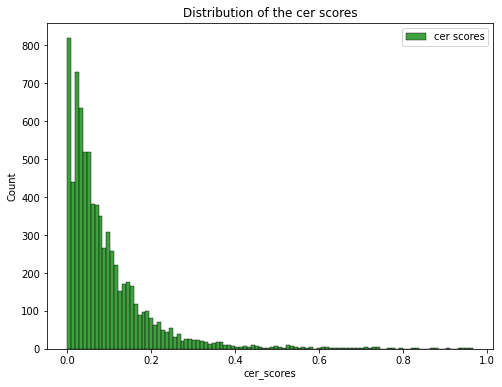

In [71]:
plt.figure(figsize=(8, 6))
# plot the cer scores
sns.histplot(results['cer_scores'], color='green', label='cer scores')
plt.legend()
plt.title('Distribution of the cer scores')
plt.savefig('cer_scores.pdf', dpi=300, bbox_inches='tight')

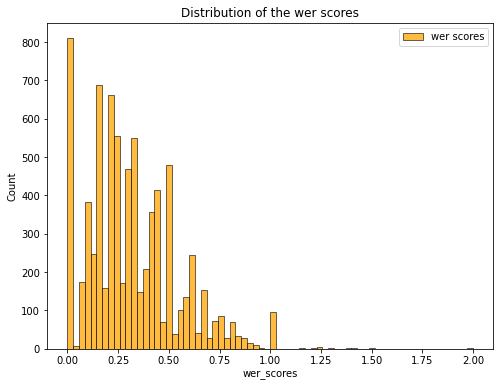

In [72]:
plt.figure(figsize=(8, 6))
# plot the wer scores
sns.histplot(results['wer_scores'], color='orange', label='wer scores')
plt.legend()
plt.title('Distribution of the wer scores')
plt.savefig('wer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 864x864 with 0 Axes>

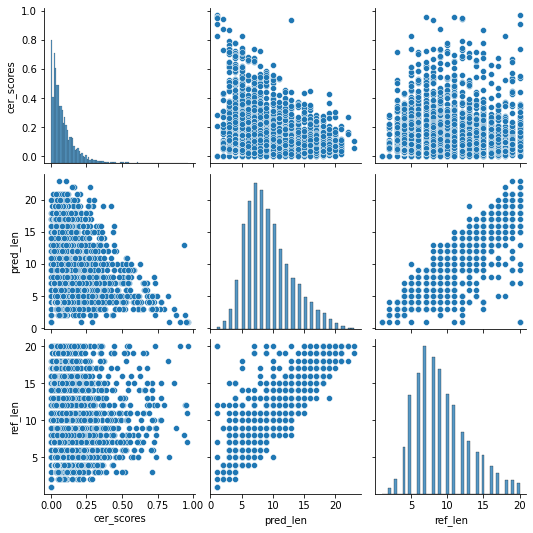

In [73]:
# show a pairplot to show the relationship between the cer scores and the number of words in the sentences
plt.figure(figsize=(12, 12))
sns.pairplot(results[['cer_scores', 'pred_len', 'ref_len']])
plt.savefig('pairplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

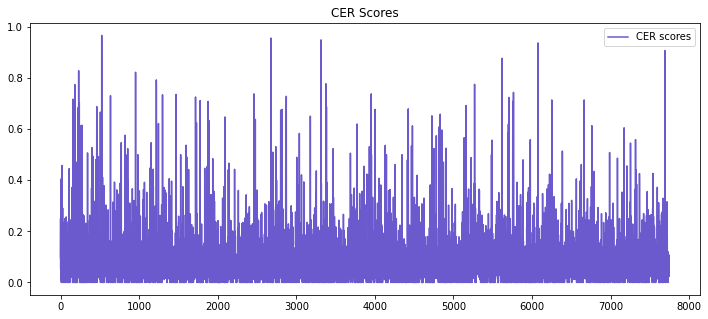

In [74]:
plt.figure(figsize=(12, 5))
# plot the cer scores
plt.plot(results['cer_scores'], color='slateblue', label='CER scores')
plt.legend()
plt.title('CER Scores')
plt.savefig('cer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

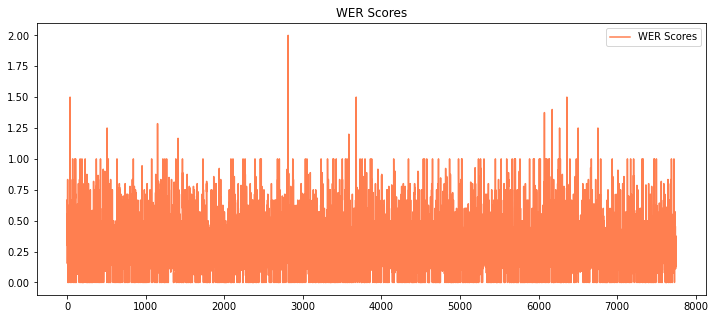

In [75]:
plt.figure(figsize=(12, 5))
# plot the cer scores
plt.plot(results['wer_scores'], color='coral', label='WER Scores')
plt.legend()
plt.title('WER Scores')
plt.savefig('wer_scores.pdf', dpi=300, bbox_inches='tight')
plt.show()

Be careful,
if you predict on train set using the best publicly available ASR bangla model from huggingface you will see the model making NaN prediction for many audio samples in train set,to get the index of those NaN output files i used the code below 

In [76]:
#no nan output in results.csv but they exist in train.csv (give it a try)
idx = [i for i, x in zip(range(len(preds)), preds) if not isinstance(x,str)]
for ele in sorted(idx, reverse = True):
    del preds[ele]
    del refs[ele]
len(preds),len(refs)


(7747, 7747)

In [91]:
df

,path,sentence
0,common_voice_bn_31675220.mp3,এছাড়াও নিউজল্যান্ড এই ক্রিকেট দলের হয়ে খেলছেন ...
1,common_voice_bn_31513116.mp3,এই ফল পাখি রাখায় কিন্তু নিজে পড়ে থাকা ফল খেলে ...
2,common_voice_bn_31558126.mp3,জন পরিকল্পিত।
3,common_voice_bn_31688693.mp3,বিভিন্ন আন্তর্জাতিক সংস্থার সদর এখানে অবস্থিত ...
4,common_voice_bn_31655323.mp3,অনেকের ধারণা ইন্দিরা রোড বার্তের প্রাক্তমপ্রবন...
...,...,...
7742,common_voice_bn_31630493.mp3,প্রধান কৃষি ফসল নাটমগআলুরিষা শাকসবজি।
7743,common_voice_bn_31630500.mp3,তিনি তার প্রাথমিক শিক্ষা তার গ্রামে পেয়েছেন।
7744,common_voice_bn_31537424.mp3,এ পর্যায়ে তার ইনি দক্ষিণ ক্রিকেই রেকর্ড বিলিকি...
7745,common_voice_bn_31591839.mp3,এছাড়া তিনি আরও অনেকগুলো গ্রন্থ রচনা করেন।


In [95]:
# save results to csv file
results.to_csv('results.csv', index=False)

In [94]:
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Tue May 23 13:24:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   2199MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
from pytorch_beam_search import seq2seq
from post_ocr_correction import correction

for i in range(len(refs)):
    refs[i] = list(refs[i])
    preds[i] = list(preds[i])


# train data and model
source = preds
target = refs
source_index = seq2seq.Index(source)
target_index = seq2seq.Index(target)
X = source_index.text2tensor(source)
Y = target_index.text2tensor(target)
print(source_index)
print(".....")
print(target_index)
print(".....")
print(X)
print(".....")
print(Y)

<Seq2Seq Index with 78 items>
.....
<Seq2Seq Index with 74 items>
.....
tensor([[ 1, 20, 57,  ...,  0,  0,  0],
        [ 1, 35, 53,  ...,  0,  0,  0],
        [ 1, 11,  7,  ...,  0,  0,  0],
        ...,
        [ 1, 22, 44,  ...,  0,  0,  0],
        [ 1, 16, 11,  ...,  0,  0,  0],
        [ 1, 20, 55,  ...,  0,  0,  0]])
.....
tensor([[ 1, 27, 64,  ...,  0,  0,  0],
        [ 1, 42, 60,  ...,  0,  0,  0],
        [ 1, 18, 14,  ...,  0,  0,  0],
        ...,
        [ 1, 29, 51,  ...,  0,  0,  0],
        [ 1, 23, 18,  ...,  0,  0,  0],
        [ 1, 27, 62,  ...,  0,  0,  0]])


In [79]:
%%time
def post_asr_corrector():
    model = seq2seq.Transformer(source_index, target_index,max_sequence_length = 256,dropout = 0.0,embedding_dimension = 192)
    return model

if (CFG.post_asr_corrector):
    print("training POST ASR Corrector...\n")
    epochs = 6000
    batch_size = 1024
    PATH = './post_ASR_corrector.pt'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    X= X.to(device)
    Y= Y.to(device)

    # def post_asr_corrector():
    #     model = seq2seq.Transformer(source_index, target_index,max_sequence_length = len(results)+4,
    #                     embedding_dimension = 512,
    #                     feedforward_dimension = 1024,
    #                     attention_heads = 2,
    #                     encoder_layers = 2,
    #                     decoder_layers = 2)
    #     return model


    model = post_asr_corrector()
    model.to(device)
    model.train()
    model.fit(X, Y, epochs = epochs, progress_bar = 1,batch_size = batch_size)
    model.eval()
    torch.save(model.state_dict(), PATH)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 21.9 µs


# load and infer

In [80]:
if (CFG.post_asr_corrector):
    del model
    torch.cuda.empty_cache()
    gc.collect()


    model = post_asr_corrector()

    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    model

In [81]:
if (CFG.post_asr_corrector):
    # test data
    test = 'শীতকালীন গেমসে এখনো কোন পদক জিততে পারেনি।'
    reference = 'শীতকালীন গেমস এ কোন কোন পদক জিততে পারেনি।'
    new_source = [list(test)]
    X_new = source_index.text2tensor(new_source).to(device)

    # plain beam search
    predictions, log_probabilities = seq2seq.beam_search(
        model, 
        X_new,
        progress_bar = 0
    )
    just_beam = target_index.tensor2text(predictions[:, 0, :])[0]
    just_beam = re.sub(r"<START>|<PAD>|<UNK>|<END>.*", "", just_beam)
    print(log_probabilities)
    print("\nresults")
    print("  test data                      ", test)
    print("  plain beam search              ", just_beam)
    #print("  disjoint windows, beam search  ", disjoint_beam)


# Subtitle

In [96]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
!pip install moviepy pydub
from moviepy.editor import *
import IPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 36.1 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=e35cc740e3c8921cbdd2ac197a1ac2b95a3b197818227536107dace6c94d62b8
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [152]:
# import the news.mp4 and extract its audio from this video
video = VideoFileClip("/kaggle/input/sample-news/news.mp4")
audio = video.audio
# make it usable for pydub
audio.write_audiofile("news.mp3")

MoviePy - Writing audio in news.mp3


MoviePy - Done.


In [163]:
# cut the audio till 45 seconds
audio = AudioSegment.from_mp3("news.mp3")
audio = audio[:45000]
audio.export("news.mp3", format="mp3")

<_io.BufferedRandom name='news.mp3'>

In [164]:
# play the audio file
IPython.display.Audio("news.mp3")

In [165]:
def milliseconds_to_timecode(milliseconds):
    """Converts milliseconds to timecode in the format hh:mm:ss,mmm"""
    seconds, milliseconds = divmod(milliseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d},{int(milliseconds):03d}"

x = AudioSegment.from_mp3("news.mp3")
chunks = split_on_silence(x, min_silence_len=600, silence_thresh=-30, keep_silence=500)

# Initialize start time to 0
start_time = 0

# Initialize an empty list to store the start and end times of each chunk
timecodes = []

# we will save each chunk of audio in a separate file 
if not os.path.isdir('chunks'):
    os.mkdir('chunks')
else:
    for filename in os.listdir('chunks'):
        os.remove(os.path.join('chunks', filename))
for i, chunk in tqdm(enumerate(chunks)):
    # Calculate the end time of the current chunk
    end_time = start_time + len(chunk)
    
    # Append the start and end times of the current chunk to the timecodes list
    start_timecode = milliseconds_to_timecode(start_time)
    end_timecode = milliseconds_to_timecode(end_time)
    timecodes.append((start_timecode, end_timecode))
    
    # Update the start time for the next chunk
    start_time = end_time
    
    # Export the current chunk as an audio file
    chunk.export(f"chunks/{i}_chunk.mp3", format="mp3")

19it [00:06,  3.11it/s]


In [166]:
# count the number of chunks from the folder and play them by ipython
# count the number of chunks
path = "chunks"
files = os.listdir(path)
print(f"Total number of chunks: {len(files)}")

# print the chunks filename
for i in range(len(files)):
    print(files[i])
    

Total number of chunks: 19
2_chunk.mp3
7_chunk.mp3
13_chunk.mp3
3_chunk.mp3
6_chunk.mp3
1_chunk.mp3
12_chunk.mp3
16_chunk.mp3
17_chunk.mp3
18_chunk.mp3
11_chunk.mp3
15_chunk.mp3
9_chunk.mp3
0_chunk.mp3
4_chunk.mp3
8_chunk.mp3
14_chunk.mp3
5_chunk.mp3
10_chunk.mp3


In [184]:
# play thefirst chunk with ipython
IPython.display.Audio("chunks/0_chunk.mp3")

In [172]:
timecodes

[('00:00:00,000', '00:00:04,956'),
 ('00:00:04,956', '00:00:07,342'),
 ('00:00:07,342', '00:00:08,849'),
 ('00:00:08,849', '00:00:10,382'),
 ('00:00:10,382', '00:00:11,837'),
 ('00:00:11,837', '00:00:13,353'),
 ('00:00:13,353', '00:00:14,315'),
 ('00:00:14,315', '00:00:19,611'),
 ('00:00:19,611', '00:00:21,400'),
 ('00:00:21,400', '00:00:22,626'),
 ('00:00:22,626', '00:00:25,076'),
 ('00:00:25,076', '00:00:27,970'),
 ('00:00:27,970', '00:00:29,249'),
 ('00:00:29,249', '00:00:31,098'),
 ('00:00:31,098', '00:00:31,992'),
 ('00:00:31,992', '00:00:33,862'),
 ('00:00:33,862', '00:00:37,899'),
 ('00:00:37,899', '00:00:40,209'),
 ('00:00:40,209', '00:00:41,413')]

In [175]:
# make a df to store the path of each chunk and its start and end time
sub_df = pd.DataFrame(columns=['path', 'start_time', 'end_time'])
# Get a list of all chunk files
files = [f for f in os.listdir('chunks') if f.endswith('.mp3')]

# Sort the files by their index
files = sorted(files, key=lambda x: int(x.split('_')[0]))

sub_df['path'] = files
sub_df['start_time'] = [i[0] for i in timecodes]
sub_df['end_time'] = [i[1] for i in timecodes]
sub_df

,path,start_time,end_time
0,0_chunk.mp3,"00:00:00,000","00:00:04,956"
1,1_chunk.mp3,"00:00:04,956","00:00:07,342"
2,2_chunk.mp3,"00:00:07,342","00:00:08,849"
3,3_chunk.mp3,"00:00:08,849","00:00:10,382"
4,4_chunk.mp3,"00:00:10,382","00:00:11,837"
5,5_chunk.mp3,"00:00:11,837","00:00:13,353"
6,6_chunk.mp3,"00:00:13,353","00:00:14,315"
7,7_chunk.mp3,"00:00:14,315","00:00:19,611"
8,8_chunk.mp3,"00:00:19,611","00:00:21,400"
9,9_chunk.mp3,"00:00:21,400","00:00:22,626"


In [176]:
# get the text from the audio chunks using the asr model and save them in df
sub_df['text'] = ''
for i in tqdm(range(len(sub_df))):
    pred = asr('chunks/'+sub_df.path[i], chunk_length_s=112, stride_length_s=None)
    sub_df.text[i] = pred['text']
sub_df

100%|██████████| 19/19 [00:06<00:00,  2.80it/s]


,path,start_time,end_time,text
0,0_chunk.mp3,"00:00:00,000","00:00:04,956",বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...
1,1_chunk.mp3,"00:00:04,956","00:00:07,342",মঙ্গলবার বিমান বাহিনী প্রধান
2,2_chunk.mp3,"00:00:07,342","00:00:08,849",এয়ার চিফ মার্শাল
3,3_chunk.mp3,"00:00:08,849","00:00:10,382",শেখ আবদুল হান্নান
4,4_chunk.mp3,"00:00:10,382","00:00:11,837",রাষ্ট্রপতির সাথে শাখা
5,5_chunk.mp3,"00:00:11,837","00:00:13,353",তে বঙ্গভবনে গেলে
6,6_chunk.mp3,"00:00:13,353","00:00:14,315",এ কথা বলেন তিন
7,7_chunk.mp3,"00:00:14,315","00:00:19,611",এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...
8,8_chunk.mp3,"00:00:19,611","00:00:21,400",রাষ্ট্রপতিকে অবহিত করেন
9,9_chunk.mp3,"00:00:21,400","00:00:22,626",বিমান বাহিনী প্রধান


In [180]:
# get an index for sub_df and then generate subtitle from the given sub_df
sub_df.index = [i for i in range(len(sub_df))]
sub_df

,path,start_time,end_time,text
0,0_chunk.mp3,"00:00:00,000","00:00:04,956",বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্য...
1,1_chunk.mp3,"00:00:04,956","00:00:07,342",মঙ্গলবার বিমান বাহিনী প্রধান
2,2_chunk.mp3,"00:00:07,342","00:00:08,849",এয়ার চিফ মার্শাল
3,3_chunk.mp3,"00:00:08,849","00:00:10,382",শেখ আবদুল হান্নান
4,4_chunk.mp3,"00:00:10,382","00:00:11,837",রাষ্ট্রপতির সাথে শাখা
5,5_chunk.mp3,"00:00:11,837","00:00:13,353",তে বঙ্গভবনে গেলে
6,6_chunk.mp3,"00:00:13,353","00:00:14,315",এ কথা বলেন তিন
7,7_chunk.mp3,"00:00:14,315","00:00:19,611",এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্...
8,8_chunk.mp3,"00:00:19,611","00:00:21,400",রাষ্ট্রপতিকে অবহিত করেন
9,9_chunk.mp3,"00:00:21,400","00:00:22,626",বিমান বাহিনী প্রধান


In [182]:
# generate the subtitle
# create a srt file
with open('subtitle.srt', 'w') as f:
    for i in range(len(sub_df)):
        f.write(str(i+1)+'\n')
        f.write(sub_df.start_time[i]+' --> '+sub_df.end_time[i]+'\n')
        f.write(sub_df.text[i]+'\n')
        f.write('\n')

In [183]:
# show the srt file
with open('subtitle.srt', 'r') as f:
    print(f.read())

1
00:00:00,000 --> 00:00:04,956
বিমান বাহিনীকে আরও এগিয়ে নিতে প্রশিক্ষণ কার্যকরণ বাড়ানোর পরামর্শ দিয়েছেন রাষ্ট্রপতি মোহাম্মদ শাহ

2
00:00:04,956 --> 00:00:07,342
মঙ্গলবার বিমান বাহিনী প্রধান

3
00:00:07,342 --> 00:00:08,849
এয়ার চিফ মার্শাল

4
00:00:08,849 --> 00:00:10,382
শেখ আবদুল হান্নান

5
00:00:10,382 --> 00:00:11,837
রাষ্ট্রপতির সাথে শাখা

6
00:00:11,837 --> 00:00:13,353
তে বঙ্গভবনে গেলে

7
00:00:13,353 --> 00:00:14,315
এ কথা বলেন তিন

8
00:00:14,315 --> 00:00:19,611
এসময় বিমানবাহিনীর উন্নয়নী নেয়া বিভিন্ন পদক্ষেপ ও বাহিনীর সার্বিক কর্মকাণ্ড সম্প

9
00:00:19,611 --> 00:00:21,400
রাষ্ট্রপতিকে অবহিত করেন

10
00:00:21,400 --> 00:00:22,626
বিমান বাহিনী প্রধান

11
00:00:22,626 --> 00:00:25,076
দেশের সার্বভমতরক্ষার পাশাপাশি

12
00:00:25,076 --> 00:00:27,970
আর্থসামাজিক উন্নয়নী বিমান বাহিনীর ভূমিকার

13
00:00:27,970 --> 00:00:29,249
প্রশংসা করেন রাষ্ট্র

14
00:00:29,249 --> 00:00:31,098
সাক্ষাতকালী রাষ্ট্রপতির কার্যালয়ের স

15
00:00:31,098 --> 00:00:31,992
পদ বড়ুয়া

16
00:00:3